In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re

In [2]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
data = pd.read_csv("data_file.csv", header = 0)

In [4]:
data.columns

Index(['name', 'description', 'Playable On', 'Genres', 'NA', 'EU', 'JP',
       'Additional Content', 'Single-Player', 'Speedrun', 'Retirement',
       'Platform', 'Type', 'Main Game', 'Multi-Player', 'Rating', 'Platform N',
       'Publishers', 'Developers'],
      dtype='object')

In [5]:
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=False)

data.head()

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Single-Player,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers
0,Bomberman: Panic Bomber,Bomberman's hunt for the Golden Bomber statue.,NaN,"['Third-Person', 'Real-Time', 'Puzzle']",NaN,NaN,"December 22, 1994",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hudson Soft,Hudson Soft
1,RIP (2014),NaN,NaN,"['First-Person', 'Shooter']","October 31, 2014",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Axyos Games,Axyos Games
2,Mr. Postman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Not enough data.': ['', '', '', '', '', '']}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Capsule,Capsule is a single-player survival game playe...,['PC'],NaN,"February 04, 2012",NaN,NaN,NaN,"{'Main Story': ['4', '1h 41m', '1h 40m', '1h 3...",NaN,5.94,"{'PC': ['10', '1h 41m', '3h', '2h 29m', '1h 22...",NaN,NaN,NaN,47.0,{'PC': '23'},Finji,NaN
4,Spectrum 2000,NaN,NaN,"['Scrolling', 'Shooter']",2000,NaN,NaN,NaN,"{'Main + Extras': ['1', '28m', '28m', '28m', '...",NaN,NaN,"{'Not enough data.': ['', '', '', '', '', '']}",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.shape[0]

70322

Se revisan los NA por variable

In [7]:
pd.DataFrame([data.isna().sum(), (data.shape[0] - data.isna().sum()), (data.isna().sum()/data.shape[0])*100], index=['isna','total-isna','% na'])

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Single-Player,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers
isna,0.0,32522.000000,45122.000000,32973.000000,32265.000000,50646.000000,63845.000000,69683.000000,44447.000000,68051.00000,50881.000000,31516.0000,68786.000000,68869.00000,68328.000000,50881.000000,48162.000000,34097.00000,32563.000000
total-isna,70322.0,37800.000000,25200.000000,37349.000000,38057.000000,19676.000000,6477.000000,639.000000,25875.000000,2271.00000,19441.000000,38806.0000,1536.000000,1453.00000,1994.000000,19441.000000,22160.000000,36225.00000,37759.000000
% na,0.0,46.247263,64.164842,46.888598,45.881801,72.020136,90.789511,99.091323,63.204971,96.77057,72.354313,44.8167,97.815762,97.93379,97.164472,72.354313,68.487813,48.48696,46.305566


In [8]:
dataAux = data.copy()    

In [9]:
from ast import literal_eval

Convert a string into a dictionary for the Genres, Single-Player, Platform, Platform N and Main Game

In [10]:
def literal_return(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val
    
dataAux["Genres"] = dataAux["Genres"].apply(lambda x: literal_return(x) if not pd.isna(x) else x)
dataAux["Single-Player"] = dataAux["Single-Player"].apply(lambda x: literal_return(x) if not pd.isna(x) else x)
dataAux["Platform"] = dataAux["Platform"].apply(lambda x: literal_return(x) if not pd.isna(x) else x)
dataAux["Platform N"] = dataAux["Platform N"].apply(lambda x: literal_return(x) if not pd.isna(x) else x)
dataAux["Main Game"] = dataAux["Main Game"].apply(lambda x: literal_return(x) if not pd.isna(x) else x)

Delete dictionaries from Platform that contains not enough data description

In [11]:
def match_not_data(data):
    try:
        if list(data.keys())[0] == 'Not enough data.':
            return np.nan
        else:
            return data
    except Exception as e:
        return data
    
dataAux["Platform"] = dataAux["Platform"].apply(lambda x: match_not_data(x)).fillna(value=np.nan)

In [12]:
pd.DataFrame([dataAux.isna().sum(), (dataAux.notna().sum())], index=['isna','total-isna'])

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Single-Player,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers
isna,0,32522,45122,32973,32265,50646,63845,69683,44447,68051,50881,48396,68786,68869,68328,50881,48162,34097,32563
total-isna,70322,37800,25200,37349,38057,19676,6477,639,25875,2271,19441,21926,1536,1453,1994,19441,22160,36225,37759


Because the main objective are the Rating, Single-Player and Platform, if at least one of them is NaN, it's deleted

In [13]:
indexNames = dataAux[dataAux['Rating'].isna()].index
dataAux.drop(indexNames , inplace=True)

In [14]:
indexNames = dataAux[dataAux['Single-Player'].isna() & dataAux["Platform"].isna()].index
dataAux.drop(indexNames , inplace=True)

In [15]:
dataAux.shape

(16735, 19)

In [16]:
pd.DataFrame([dataAux.isna().sum(), (dataAux.notna().sum())], index=['isna','total-isna'])

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Single-Player,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers
isna,0,965,725,1012,959,9013,13102,16150,0,14651,0,836,16044,16050,15201,0,836,2659,2408
total-isna,16735,15770,16010,15723,15776,7722,3633,585,16735,2084,16735,15899,691,685,1534,16735,15899,14076,14327


Convert NA, EU, JP strings into date, however, if the date is only a year, the result date contains a day and a month (TAKE CARE)

In [17]:
from dateutil.parser import parse


def parse_game_dates(dateStr):
    date = None
    try:
        dateAux = parse(dateStr)
        return dateAux.date()
        #date = pd.to_datetime(dateStr), format="%B %d, %Y")
    except Exception as e:
        return dateStr
        
dataAux["NA"] = dataAux["NA"].apply(lambda x: parse_game_dates(x))
dataAux["EU"] = dataAux["EU"].apply(lambda x: parse_game_dates(x))
dataAux["JP"] = dataAux["JP"].apply(lambda x: parse_game_dates(x))
aux = parse('1988')
print(aux.date())

1988-09-11


In [18]:
dataAux.head()

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Single-Player,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers
3,Capsule,Capsule is a single-player survival game playe...,['PC'],NaN,2012-02-04,NaN,NaN,NaN,"{'Main Story': ['4', '1h 41m', '1h 40m', '1h 3...",NaN,5.94,"{'PC': ['10', '1h 41m', '3h', '2h 29m', '1h 22...",NaN,NaN,NaN,47.0,{'PC': '23'},Finji,NaN
7,Fantasy Zone II: The Tears of Opa-Opa,NaN,"['Nintendo 3DS', 'Sega Master System']","[Scrolling, Shooter]",1987-12-11,1988-09-11,NaN,NaN,"{'Main Story': ['8', '1h 26m', '1h 30m', '59m'...",NaN,6.90,"{'Nintendo 3DS': ['3', '1h 48m', '--', '--', '...",NaN,NaN,NaN,70.0,"{'Nintendo 3DS': '4', 'Sega Master System': '7'}",NaN,NaN
11,Siege of Avalon,Siege of Avalon is a traditional fantasy-RPG w...,['PC'],"[Top-Down, Real-Time, Action, Role-Playing]",2000-04-27,NaN,NaN,NaN,"{'Main + Extras': ['3', '22h 31m', '26h', '16h...",NaN,11.11,"{'PC': ['3', '--', '22h 31m', '--', '9h 34m', ...",NaN,NaN,NaN,40.0,{'PC': '4'},NaN,Digital Tome
16,Codename: Outbreak,"In the early 21st century, a meteor storm hits...",['PC'],"[First-Person, Shooter]",2001-11-25,NaN,NaN,NaN,"{'Main Story': ['2', '5h 59m', '5h 59m', '4h 5...",NaN,15.38,"{'PC': ['2', '5h 59m', '--', '--', '4h', '7h 5...",NaN,NaN,NaN,60.0,{'PC': '4'},Virgin Interactive,GSC Game World
22,A Bird Story,"From the creator of To the Moon: A simple, wor...",['PC'],Adventure,2014-11-07,2014-11-07,NaN,NaN,"{'Main Story': ['314', '1h 17m', '1h 12m', '52...",NaN,2.16,"{'PC': ['612', '1h 17m', '1h 27m', '1h 27m', '...",NaN,NaN,NaN,68.0,{'PC': '1.5K'},Freebird Games,Freebird Games


Convert each number from Platform N, Single-Player and Platform from a string into a number

In [19]:
def convert_platform_to_thousands(dicts):
    if type(dicts) == dict:
        for key, value in dicts.items():
            try:
                if value.isdigit():
                    dicts[key] =  int(value)
                else:
                    value = int(float(value.strip( 'K' ))*1000)
                    dicts[key] = value
            except Exception as e:
                pass
    return dicts 
    

dataAux["Platform N"] = dataAux["Platform N"].apply(lambda x: convert_platform_to_thousands(x))

In [20]:
dataAux["Single-Player"][3]


{'Main Story': ['4', '1h 41m', '1h 40m', '1h 32m', '1h 50m'],
 'Main + Extras': ['1', '3h', '3h', '3h', '3h'],
 'Completionists': ['5', '2h 29m', '2h 08m', '1h 50m', '3h 09m'],
 'All PlayStyles': ['10', '2h 13m', '1h 59m', '1h 44m', '3h 03m']}

**Elementos del array de Single-Player y Platform**

Polled(Siempre un numero)	Average(Horas minutos)	Median(Horas minutos)	Rushed(Horas minutos)	Leisure(Horas minutos)

Estos numeros reflejan los resultados obtenidos para la cateogria listada en el diccionario.

Se reconvierten a segundos todos menos el primero.

In [21]:
def convert_text_to_number(dicts):
    if type(dicts) == dict:
        for key, value in dicts.items():
            try:
                for count, item in enumerate(value):
                    #print(count, type(item))
                    try:
                        if type(item) is int:
                            value[count] =  int(item) #si es un número se mantiene como tal
                        elif type(item) is str:
                            seconds = 0
                            for time in item.split(" "):
                                if(time[-1] == "h"):
                                    seconds += int(time[:-1]) * 3600
                                elif(time[-1] == "m"):
                                    seconds += int(time[:-1]) * 60                            
                            value[count] = seconds
                            dicts[key] = value
                            
                    except Exception as e:
                        pass
            except Exception as e:
                pass
    return dicts 
    

dataAux["Single-Player"] = dataAux["Single-Player"].apply(lambda x: convert_text_to_number(x))
dataAux["Platform"] = dataAux["Platform"].apply(lambda x: convert_text_to_number(x))

In [22]:
dataAux.head()

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Single-Player,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers
3,Capsule,Capsule is a single-player survival game playe...,['PC'],NaN,2012-02-04,NaN,NaN,NaN,"{'Main Story': [0, 6060, 6000, 5520, 6600], 'M...",NaN,5.94,"{'PC': [0, 6060, 10800, 8940, 4920, 14400]}",NaN,NaN,NaN,47.0,{'PC': 23},Finji,NaN
7,Fantasy Zone II: The Tears of Opa-Opa,NaN,"['Nintendo 3DS', 'Sega Master System']","[Scrolling, Shooter]",1987-12-11,1988-09-11,NaN,NaN,"{'Main Story': [0, 5160, 5400, 3540, 7020], 'A...",NaN,6.90,"{'Nintendo 3DS': [0, 6480, 0, 0, 3720, 8760], ...",NaN,NaN,NaN,70.0,"{'Nintendo 3DS': 4, 'Sega Master System': 7}",NaN,NaN
11,Siege of Avalon,Siege of Avalon is a traditional fantasy-RPG w...,['PC'],"[Top-Down, Real-Time, Action, Role-Playing]",2000-04-27,NaN,NaN,NaN,"{'Main + Extras': [0, 81060, 93600, 60900, 101...",NaN,11.11,"{'PC': [0, 0, 81060, 0, 34440, 115200]}",NaN,NaN,NaN,40.0,{'PC': 4},NaN,Digital Tome
16,Codename: Outbreak,"In the early 21st century, a meteor storm hits...",['PC'],"[First-Person, Shooter]",2001-11-25,NaN,NaN,NaN,"{'Main Story': [0, 21540, 21540, 17940, 25080]...",NaN,15.38,"{'PC': [0, 21540, 0, 0, 14400, 28680]}",NaN,NaN,NaN,60.0,{'PC': 4},Virgin Interactive,GSC Game World
22,A Bird Story,"From the creator of To the Moon: A simple, wor...",['PC'],Adventure,2014-11-07,2014-11-07,NaN,NaN,"{'Main Story': [0, 4620, 4320, 3120, 7620], 'M...",NaN,2.16,"{'PC': [0, 4620, 5220, 5220, 1800, 18540]}",NaN,NaN,NaN,68.0,{'PC': 1500},Freebird Games,Freebird Games


Single players Main Story Na:  1780


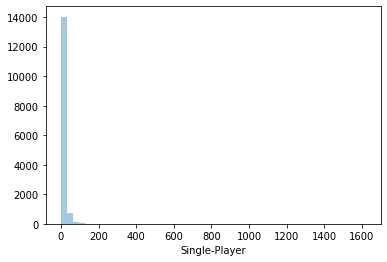

In [23]:
#Esta funcion pone en na todos los que no tienen Main Story, (ya sea porque no tienen o porque es main + extras)
def get_mainStory (dict):
    if "Main Story" in dict.keys():
        return dict["Main Story"][1]/3600

spAverage = dataAux["Single-Player"].apply(lambda x: get_mainStory(x)).dropna()#Promedios
print("Single players Main Story Na: ", dataAux["Single-Player"].shape[0] - spAverage.shape[0])
sns.distplot(spAverage, kde= False);

In [24]:
pd.DataFrame(spAverage.describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Single-Player,14955.0,10.750388,27.601031,0.0,2.3,5.55,11.625,1617.466667


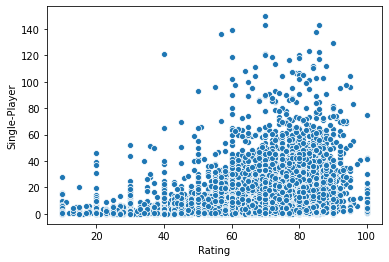

In [25]:
spMainStory = dataAux["Single-Player"].apply(lambda x: get_mainStory(x))
rating = dataAux["Rating"]
sns.scatterplot(rating[spMainStory < 150], spMainStory[spMainStory < 150]);

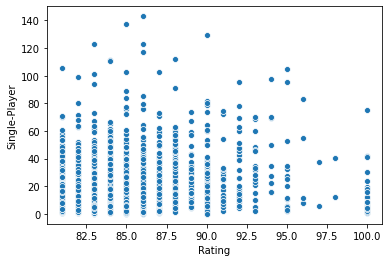

In [26]:
sns.scatterplot(rating[(rating > 80) & (spMainStory < 150)], spMainStory[(rating > 80) & (spMainStory < 150)]);

In [27]:
dataAux.head()

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Single-Player,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers
3,Capsule,Capsule is a single-player survival game playe...,['PC'],NaN,2012-02-04,NaN,NaN,NaN,"{'Main Story': [0, 6060, 6000, 5520, 6600], 'M...",NaN,5.94,"{'PC': [0, 6060, 10800, 8940, 4920, 14400]}",NaN,NaN,NaN,47.0,{'PC': 23},Finji,NaN
7,Fantasy Zone II: The Tears of Opa-Opa,NaN,"['Nintendo 3DS', 'Sega Master System']","[Scrolling, Shooter]",1987-12-11,1988-09-11,NaN,NaN,"{'Main Story': [0, 5160, 5400, 3540, 7020], 'A...",NaN,6.90,"{'Nintendo 3DS': [0, 6480, 0, 0, 3720, 8760], ...",NaN,NaN,NaN,70.0,"{'Nintendo 3DS': 4, 'Sega Master System': 7}",NaN,NaN
11,Siege of Avalon,Siege of Avalon is a traditional fantasy-RPG w...,['PC'],"[Top-Down, Real-Time, Action, Role-Playing]",2000-04-27,NaN,NaN,NaN,"{'Main + Extras': [0, 81060, 93600, 60900, 101...",NaN,11.11,"{'PC': [0, 0, 81060, 0, 34440, 115200]}",NaN,NaN,NaN,40.0,{'PC': 4},NaN,Digital Tome
16,Codename: Outbreak,"In the early 21st century, a meteor storm hits...",['PC'],"[First-Person, Shooter]",2001-11-25,NaN,NaN,NaN,"{'Main Story': [0, 21540, 21540, 17940, 25080]...",NaN,15.38,"{'PC': [0, 21540, 0, 0, 14400, 28680]}",NaN,NaN,NaN,60.0,{'PC': 4},Virgin Interactive,GSC Game World
22,A Bird Story,"From the creator of To the Moon: A simple, wor...",['PC'],Adventure,2014-11-07,2014-11-07,NaN,NaN,"{'Main Story': [0, 4620, 4320, 3120, 7620], 'M...",NaN,2.16,"{'PC': [0, 4620, 5220, 5220, 1800, 18540]}",NaN,NaN,NaN,68.0,{'PC': 1500},Freebird Games,Freebird Games


Se despivotan las columnas Single-Player

In [28]:
dataAux_desp = dataAux.copy()

In [29]:
def changeWord(word):
    for letter in word:
        if letter == "-" or letter == "/" or letter == "'" or letter == "." or letter == "&" or letter == "+":
            word = word.replace(letter,"_")
    return word

In [30]:
#Despivote de Additional Content
def despivotar_col(col_name, namePrefix, data):
    #Se obtienen los elementos (keys) de los diccionarios de Single player
    elements = []
    for game in data[col_name]:
            for element in game.keys():
                if element not in elements:
                    elements.append(element)

    print(elements)


    def get_element_from_game(x, element):
        #Dado un elemento del diccionario de "Single player" retorna sus datos
        if type(x) is dict:
            if element in x.keys():
                return x[element]

    #Para cada elemento se añade una columna nueva con SP al principio para idicar que es single player
    for element in elements:
        #element = ''.join(element.split())
        data[(namePrefix + element)] = data[col_name].apply(lambda x: get_element_from_game(x,element))
        nameCol = namePrefix + element
        renameCol = ''.join(nameCol.split())
        data = data.rename(columns={nameCol: renameCol})


    #Se elimina la columna original
    data.drop([col_name], axis='columns', inplace=True)  
    return data

dataAux_desp = despivotar_col("Single-Player", "SP_", dataAux_desp)


['Main Story', 'Main + Extras', 'Completionists', 'All PlayStyles']


In [31]:
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=False)

dataAux_desp.head()

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers,SP_MainStory,SP_Main+Extras,SP_Completionists,SP_AllPlayStyles
3,Capsule,Capsule is a single-player survival game playe...,['PC'],NaN,2012-02-04,NaN,NaN,NaN,NaN,5.94,"{'PC': [0, 6060, 10800, 8940, 4920, 14400]}",NaN,NaN,NaN,47.0,{'PC': 23},Finji,NaN,"[0, 6060, 6000, 5520, 6600]","[0, 10800, 10800, 10800, 10800]","[0, 8940, 7680, 6600, 11340]","[0, 7980, 7140, 6240, 10980]"
7,Fantasy Zone II: The Tears of Opa-Opa,NaN,"['Nintendo 3DS', 'Sega Master System']","[Scrolling, Shooter]",1987-12-11,1988-09-11,NaN,NaN,NaN,6.90,"{'Nintendo 3DS': [0, 6480, 0, 0, 3720, 8760], ...",NaN,NaN,NaN,70.0,"{'Nintendo 3DS': 4, 'Sega Master System': 7}",NaN,NaN,"[0, 5160, 5400, 3540, 7020]",None,None,"[0, 5160, 5400, 3540, 7020]"
11,Siege of Avalon,Siege of Avalon is a traditional fantasy-RPG w...,['PC'],"[Top-Down, Real-Time, Action, Role-Playing]",2000-04-27,NaN,NaN,NaN,NaN,11.11,"{'PC': [0, 0, 81060, 0, 34440, 115200]}",NaN,NaN,NaN,40.0,{'PC': 4},NaN,Digital Tome,None,"[0, 81060, 93600, 60900, 101220]",None,"[0, 81060, 93600, 60900, 101220]"
16,Codename: Outbreak,"In the early 21st century, a meteor storm hits...",['PC'],"[First-Person, Shooter]",2001-11-25,NaN,NaN,NaN,NaN,15.38,"{'PC': [0, 21540, 0, 0, 14400, 28680]}",NaN,NaN,NaN,60.0,{'PC': 4},Virgin Interactive,GSC Game World,"[0, 21540, 21540, 17940, 25080]",None,None,"[0, 21540, 21540, 17940, 25080]"
22,A Bird Story,"From the creator of To the Moon: A simple, wor...",['PC'],Adventure,2014-11-07,2014-11-07,NaN,NaN,NaN,2.16,"{'PC': [0, 4620, 5220, 5220, 1800, 18540]}",NaN,NaN,NaN,68.0,{'PC': 1500},Freebird Games,Freebird Games,"[0, 4620, 4320, 3120, 7620]","[0, 5220, 4620, 4260, 7860]","[0, 5220, 4560, 3900, 11700]","[0, 4920, 4440, 3240, 11580]"


Ahora se juntan las columnas Playable On,  	Platform y  Platform N, asi como se despivotan.

In [32]:
#Se despivota Platform
#Despivote de Additional Content
elements = []
def despivotar_col(col_name, namePrefix, data):
    #Se obtienen los elementos (keys) de los diccionarios de Single player
    for game in dataAux_desp[col_name]:
        if not (type(game) is float):
            for element in game.keys():
                if element not in elements:
                    elements.append(element)

    #print(elements)


    def get_element_from_game(x, element):
        #Dado un elemento del diccionario de "Single player" retorna sus datos
        if type(x) is dict:
            if element in x.keys():
                return x[element]

    #Para cada elemento se añade una columna nueva con SP al principio para idicar que es single player
    for count,element in enumerate(elements):
        data[(namePrefix + element)] = data[col_name].apply(lambda x: get_element_from_game(x,element))
        nameCol = namePrefix + element
        renameCol = changeWord(''.join(nameCol.split()))
        data = data.rename(columns={nameCol: renameCol})
        elements[count] = changeWord(''.join(element.split()))


    #Se elimina la columna original
    data.drop([col_name], axis='columns', inplace=True)  
    return data
    
dataAux_desp = despivotar_col("Platform N","N_", dataAux_desp)
games = elements

In [33]:
for game in games:
    dataAux_desp["N_" + game] = dataAux_desp["N_" + game].fillna(0)

In [34]:
gameNTotal = []
for game in games:
    gameNTotal.append(dataAux_desp["N_" + game].sum())

In [35]:
np.mean(gameNTotal)

41252.42622950819

In [36]:
topPlatforms = pd.DataFrame(gameNTotal, games)[0][pd.DataFrame(gameNTotal, games)[0] > np.mean(gameNTotal)]

In [37]:
topPlatforms = topPlatforms.sort_values()

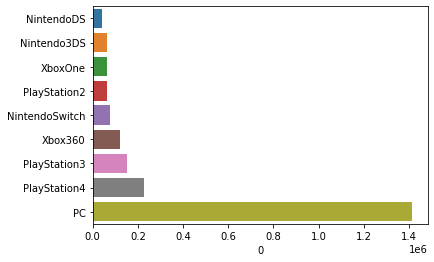

In [38]:
sns.barplot(topPlatforms, topPlatforms.index);

**Despivotar la columna de Generos**

In [39]:
genres = []

#Se obtienen los elementos (keys) de los diccionarios de Single player
for game in dataAux_desp["Genres"]:
    if not (type(game) is float):
        if type(game) is list:
            for element in game:
                if element not in genres:
                    genres.append(element)
            else:
                if element not in genres:
                    genres.append(element)

#print(genres)
def check (x, element):
    if type(x) is float:
        pass
    else:
        if type(x) is list:
            if element in x:
                return 1
            else:
                return 0
        else:
            if x == element:
                return 1
            else:
                return 0
#Para cada elemento se añade una columna nueva con SP al principio para idicar que es single player
for element in genres:
    dataAux_desp[("G_" + element)] = dataAux_desp["Genres"].apply(lambda x: check(x, element))
    nameCol = "G_" + element
    renameCol = changeWord(''.join(nameCol.split()))
    dataAux_desp = dataAux_desp.rename(columns={nameCol: renameCol})

    
print("done")

done


In [40]:
dataAux_desp.head()

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Publishers,Developers,SP_MainStory,SP_Main+Extras,SP_Completionists,SP_AllPlayStyles,N_PC,N_Nintendo3DS,N_SegaMasterSystem,N_PlayStation3,N_PlayStation4,N_Xbox360,N_NintendoSwitch,N_XboxOne,N_NES,N_PlayStationVita,N_PlayStation,N_Mobile,N_WiiU,N_GameBoyAdvance,N_ZXSpectrum,N_Arcade,N_SegaMegaDrive_Genesis,N_PlayStation2,N_NintendoDS,N_PSP,N_NintendoGameCube,N_SegaSaturn,N_Wii,N_Amiga,N_GameBoyColor,N_Emulated,N_NECPC_9801_21,N_Nintendo64,N_SuperNintendo,N_GoogleStadia,N_Atari2600,N_PlayStationVR,N_Browser,N_Xbox,N_GameBoy,N_N_Gage,N_VirtualBoy,N_PCVR,N_PlayStationNow,N_OculusQuest,N_Dreamcast,N_SegaCD,N_AppleII,N_TurboGrafx_16,N_AtariJaguar,N_NeoGeo,N_OnLive,N_SegaGameGear,N_AtariLynx,N_TurboGrafx_CD,N_Commodore64,N_NeoGeoPocket,N_Atari5200,N_Sega32X,N_WonderSwan,N_Atari7800,N_Game_Watch,N_3DO,N_Ouya,N_MSX,N_NeoGeoCD,G_Scrolling,G_Shooter,G_Top_Down,G_Real_Time,G_Action,G_Role_Playing,G_First_Person,G_Adventure,G_Puzzle,G_Strategy,G_Multidirectional,G_Platform,G_SurvivalHorror,G_Point_and_Click,G_Compilation,G_Tactical,G_Arcade,G_Racing_Driving,G_Turn_Based,G_Text,G_Fighting,G_Pinball,G_Horror,G_Survival,G_Third_Person,G_HiddenObject,G_MassivelyMultiplayer,G_Racing,G_Simulation,G_Stealth,G_Sports,G_BoardGame,G_TowerDefense,G_Beat_emUp,G_HackandSlash,G_On_Rails,G_VisualNovel,G_City_Building,G_Roguelike,G_InteractiveArt,G_OpenWorld,G_Party,G_CarCombat,G_Sandbox,G_VirtualReality,G_Side,G_VehicularCombat,G_BattleArena,G_Music_Rhythm,G_Educational,G_FlightCombat,G_CardGame,G_Flight,G_Fitness,G_Strategy_Tactical,G_Isometric,G_Platformer,G_role_playing,G_CombatFlightSimulator,G_Third_person,G_action_adventure,G_side_scroller,G_Side_scroller,G_Shoot_emup,G_Flightsimulator,G_Shoot_em_up,G_Top_down,G_3_D,G_Survivalhorror,G_actionadventure,G_action,G_adventure,G_City_building,G_Real_timeStrategy,G_Light_GunShooter,G_Third_personshooter,G_MechaSimulation,G_Side_Scroller,G_Shoot_emUp,G_Beat_emup,G_RPG,G_Graphicadventure,G_Point_and_clickadventure,G_Role_playinggame,G_Action_adventuregame,G_Stealthgame,G_Beat,G_Real_timetactics,G_platformer,G_Casual,G_Indie,G_hackandslash,G_educational,G_Music,G_post_retro,G_Scrollingshooter,G_music,G_Various,G_Fightinggame,G_Visualnovel,G_Americanfootball,G_Hackandslash,G_Vehicularcombat,G_puzzle,G_First_person,G_Tacticalshooter,G_Family,G_first_personshooter,G_Action_adventure,G_platforming,G_ActionRPG,G_Adventuregame,G_Third_personShooter,G_Mini_Games,G_FMV,G_FamilyGames,G_Sidescrolling,G_platform,G_Rhythm,G_Exercise,G_Third_personhackandslash,G_Firstperson,G_Sport,G_minigames,G_First_personshooter,G_survivalhorror,G_Real_TimeStrategy,G_DungeonCrawl,G_Role_playing,G_digitalpet,G_Dramatic_InnovativeRPG,G_third_personshooter,G_Real_timeTactics,G_interactivemovie,G_roleplaying,G_Aerialcombat,G_Driving,G_Third_PersonShooter,G_Sciencefiction,G_Real_timestrategy,G_Godgame,G_Computerrole_playinggame,G_Tacticalaction,G_Cardbattle,G_turn_basedstrategy,G_turn_basedtactics,G_Hack_and_slash,G_Runandgun,G_Simulator,G_Tacticalrole_playinggame,G_sandbox,G_CombatSimulation,G_Tactics,G_Real_timetacticalshooter,G_strategyside_scroller,G_Hack_n_Slash,G_MedievalFantasyAction,G_Shooting,G_flightsimulator,G_RTS,G_Socialsimulation,G_Puzzlegame,G_City_Builder,G_Spacesimulation,G_Golf,G_shooter,G_First_personShooter,G_DungeonCrawler,G_dungeoncrawl,G_Side_scrollingplatform,G_shoot_emup,G_graphicadventure,G_3DPlatform,G_Platforming,G_railshooter,G_Sportsgame,G_Turn_BasedStrategy,G_Wrestling,G_Side_scrolling,G_Moba,G_Turn_basedstrategy,G_CardBattle,G_Psychologicalhorror,G_Mecha,G_strategy,G_Stealth_basedgame,G_collectiblecardgame,G_turn_basedtactical,G_Stealthaction,G_Mechasimulationgame,G_runandgun,G_arcade,G_Crossover,G_Beat_emup,G_Platformgame,G_Computerrole_playing,G_First_PersonShooter,G_ActionAdventure,G_StrategyRPG,G_TacticalShooter,G_Openworld,G_Maze,G_Actionrole_playing,G_Rhythmgame,G_stealth,G_I

<AxesSubplot:xlabel='Retirement'>

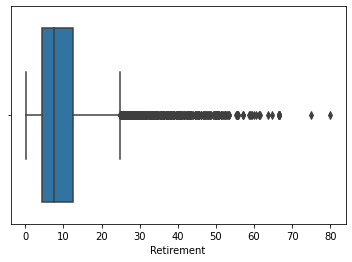

In [41]:
sns.boxplot(x=dataAux_desp["Retirement"])

<AxesSubplot:xlabel='Rating'>

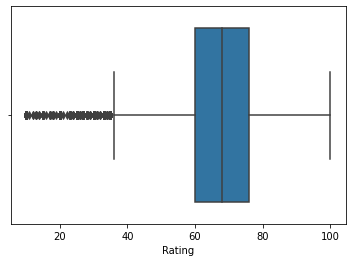

In [42]:
sns.boxplot(x=dataAux_desp["Rating"])

# NA/JP/EU vs Rating

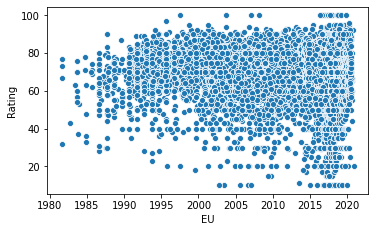

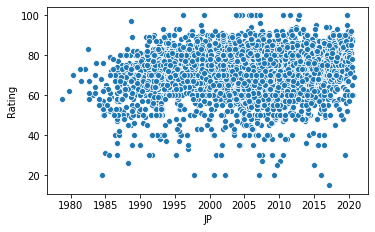

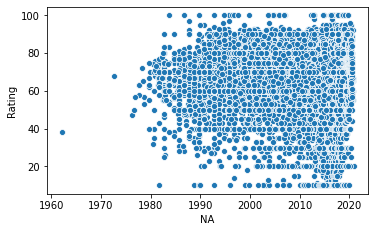

In [43]:
import datetime
launchLocation = ["EU", "JP", "NA"]

rating = dataAux_desp["Rating"]

for ll in launchLocation:

    fig, axs = plt.subplots()
    fig.tight_layout(pad = 4)

    sns.scatterplot(dataAux_desp[ll], rating , ax = axs);


# Top Publishers count and Publishers by rating

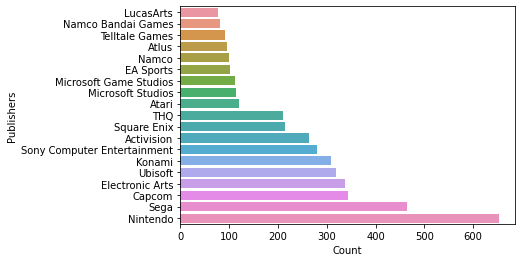

In [44]:
publishers_count=dataAux_desp.groupby(["Publishers"])["Publishers"].count().sort_values()
topPublishers = pd.DataFrame(publishers_count.values, publishers_count.index)

topPublishersAux = topPublishers[topPublishers[0] > 75]

ax = sns.barplot(topPublishersAux[0], topPublishersAux.index)
ax.set(xlabel='Count', ylabel='Publishers');

In [45]:
dataAux_desp.head()

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Publishers,Developers,SP_MainStory,SP_Main+Extras,SP_Completionists,SP_AllPlayStyles,N_PC,N_Nintendo3DS,N_SegaMasterSystem,N_PlayStation3,N_PlayStation4,N_Xbox360,N_NintendoSwitch,N_XboxOne,N_NES,N_PlayStationVita,N_PlayStation,N_Mobile,N_WiiU,N_GameBoyAdvance,N_ZXSpectrum,N_Arcade,N_SegaMegaDrive_Genesis,N_PlayStation2,N_NintendoDS,N_PSP,N_NintendoGameCube,N_SegaSaturn,N_Wii,N_Amiga,N_GameBoyColor,N_Emulated,N_NECPC_9801_21,N_Nintendo64,N_SuperNintendo,N_GoogleStadia,N_Atari2600,N_PlayStationVR,N_Browser,N_Xbox,N_GameBoy,N_N_Gage,N_VirtualBoy,N_PCVR,N_PlayStationNow,N_OculusQuest,N_Dreamcast,N_SegaCD,N_AppleII,N_TurboGrafx_16,N_AtariJaguar,N_NeoGeo,N_OnLive,N_SegaGameGear,N_AtariLynx,N_TurboGrafx_CD,N_Commodore64,N_NeoGeoPocket,N_Atari5200,N_Sega32X,N_WonderSwan,N_Atari7800,N_Game_Watch,N_3DO,N_Ouya,N_MSX,N_NeoGeoCD,G_Scrolling,G_Shooter,G_Top_Down,G_Real_Time,G_Action,G_Role_Playing,G_First_Person,G_Adventure,G_Puzzle,G_Strategy,G_Multidirectional,G_Platform,G_SurvivalHorror,G_Point_and_Click,G_Compilation,G_Tactical,G_Arcade,G_Racing_Driving,G_Turn_Based,G_Text,G_Fighting,G_Pinball,G_Horror,G_Survival,G_Third_Person,G_HiddenObject,G_MassivelyMultiplayer,G_Racing,G_Simulation,G_Stealth,G_Sports,G_BoardGame,G_TowerDefense,G_Beat_emUp,G_HackandSlash,G_On_Rails,G_VisualNovel,G_City_Building,G_Roguelike,G_InteractiveArt,G_OpenWorld,G_Party,G_CarCombat,G_Sandbox,G_VirtualReality,G_Side,G_VehicularCombat,G_BattleArena,G_Music_Rhythm,G_Educational,G_FlightCombat,G_CardGame,G_Flight,G_Fitness,G_Strategy_Tactical,G_Isometric,G_Platformer,G_role_playing,G_CombatFlightSimulator,G_Third_person,G_action_adventure,G_side_scroller,G_Side_scroller,G_Shoot_emup,G_Flightsimulator,G_Shoot_em_up,G_Top_down,G_3_D,G_Survivalhorror,G_actionadventure,G_action,G_adventure,G_City_building,G_Real_timeStrategy,G_Light_GunShooter,G_Third_personshooter,G_MechaSimulation,G_Side_Scroller,G_Shoot_emUp,G_Beat_emup,G_RPG,G_Graphicadventure,G_Point_and_clickadventure,G_Role_playinggame,G_Action_adventuregame,G_Stealthgame,G_Beat,G_Real_timetactics,G_platformer,G_Casual,G_Indie,G_hackandslash,G_educational,G_Music,G_post_retro,G_Scrollingshooter,G_music,G_Various,G_Fightinggame,G_Visualnovel,G_Americanfootball,G_Hackandslash,G_Vehicularcombat,G_puzzle,G_First_person,G_Tacticalshooter,G_Family,G_first_personshooter,G_Action_adventure,G_platforming,G_ActionRPG,G_Adventuregame,G_Third_personShooter,G_Mini_Games,G_FMV,G_FamilyGames,G_Sidescrolling,G_platform,G_Rhythm,G_Exercise,G_Third_personhackandslash,G_Firstperson,G_Sport,G_minigames,G_First_personshooter,G_survivalhorror,G_Real_TimeStrategy,G_DungeonCrawl,G_Role_playing,G_digitalpet,G_Dramatic_InnovativeRPG,G_third_personshooter,G_Real_timeTactics,G_interactivemovie,G_roleplaying,G_Aerialcombat,G_Driving,G_Third_PersonShooter,G_Sciencefiction,G_Real_timestrategy,G_Godgame,G_Computerrole_playinggame,G_Tacticalaction,G_Cardbattle,G_turn_basedstrategy,G_turn_basedtactics,G_Hack_and_slash,G_Runandgun,G_Simulator,G_Tacticalrole_playinggame,G_sandbox,G_CombatSimulation,G_Tactics,G_Real_timetacticalshooter,G_strategyside_scroller,G_Hack_n_Slash,G_MedievalFantasyAction,G_Shooting,G_flightsimulator,G_RTS,G_Socialsimulation,G_Puzzlegame,G_City_Builder,G_Spacesimulation,G_Golf,G_shooter,G_First_personShooter,G_DungeonCrawler,G_dungeoncrawl,G_Side_scrollingplatform,G_shoot_emup,G_graphicadventure,G_3DPlatform,G_Platforming,G_railshooter,G_Sportsgame,G_Turn_BasedStrategy,G_Wrestling,G_Side_scrolling,G_Moba,G_Turn_basedstrategy,G_CardBattle,G_Psychologicalhorror,G_Mecha,G_strategy,G_Stealth_basedgame,G_collectiblecardgame,G_turn_basedtactical,G_Stealthaction,G_Mechasimulationgame,G_runandgun,G_arcade,G_Crossover,G_Beat_emup,G_Platformgame,G_Computerrole_playing,G_First_PersonShooter,G_ActionAdventure,G_StrategyRPG,G_TacticalShooter,G_Openworld,G_Maze,G_Actionrole_playing,G_Rhythmgame,G_stealth,G_I

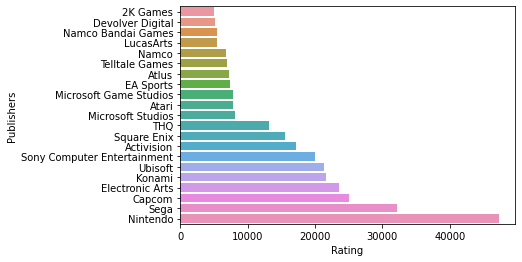

In [46]:

publishers_by_rating = dataAux_desp[["Publishers", "Rating"]].groupby(["Publishers"]).sum().sort_values(by=["Rating"])
top_publishers_by_rating = pd.DataFrame(publishers_by_rating.values, publishers_by_rating.index)

top_publishers_by_ratingAux = top_publishers_by_rating[top_publishers_by_rating[0] > 5000]


ax = sns.barplot(top_publishers_by_ratingAux[0].values, top_publishers_by_ratingAux.index)
ax.set(xlabel='Rating', ylabel='Publishers');

# Top Pevelopers count and Pevelopers by rating

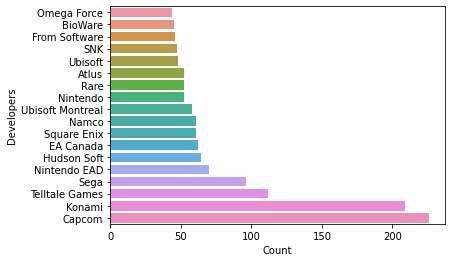

In [47]:
developers_count=dataAux_desp.groupby(["Developers"])["Developers"].count().sort_values()
topDevelopers = pd.DataFrame(developers_count.values, developers_count.index)

topDevelopersAux = topDevelopers[topDevelopers[0] > 40]

ax = sns.barplot(topDevelopersAux[0], topDevelopersAux.index)
ax.set(xlabel='Count', ylabel='Developers');

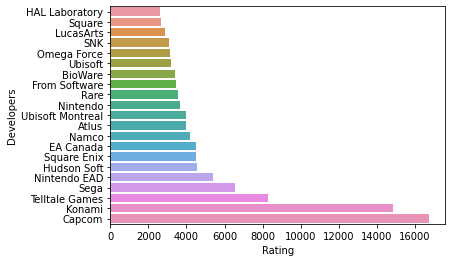

In [48]:
developers_by_rating = dataAux_desp[["Developers", "Rating"]].groupby(["Developers"]).sum().sort_values(by=["Rating"])
top_developers_by_rating = pd.DataFrame(developers_by_rating.values, developers_by_rating.index)

top_developers_by_ratingAux = top_developers_by_rating[top_developers_by_rating[0] > 2500]


ax = sns.barplot(top_developers_by_ratingAux[0].values, top_developers_by_ratingAux.index)
ax.set(xlabel='Rating', ylabel='Developers');

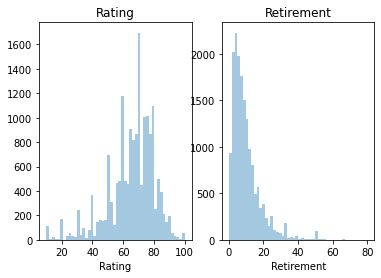

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Rating")
sns.distplot(dataAux_desp["Rating"], kde= False, ax = ax1)
ax2.set_title("Retirement")
sns.distplot(dataAux_desp["Retirement"], kde= False,ax = ax2)
plt.show()

Single players Main Story Na:  1780


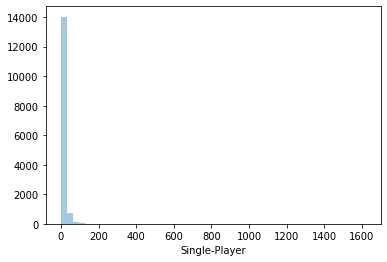

In [50]:
#Esta funcion pone en na todos los que no tienen Main Story, (ya sea porque no tienen o porque es main + extras)
def get_mainStory (dict):
    if "Main Story" in dict.keys():
        return dict["Main Story"][1]/3600

spAverage = dataAux["Single-Player"].apply(lambda x: get_mainStory(x)).dropna()#Promedios
print("Single players Main Story Na: ", dataAux["Single-Player"].shape[0] - spAverage.shape[0])
sns.distplot(spAverage, kde= False);

<AxesSubplot:xlabel='Rating', ylabel='Single-Player'>

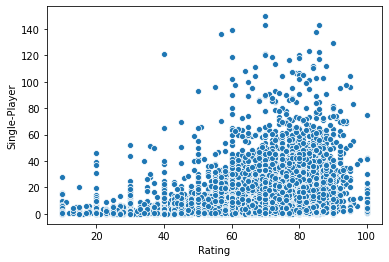

In [51]:
spMainStory = dataAux["Single-Player"].apply(lambda x: get_mainStory(x))
rating = dataAux["Rating"]
sns.scatterplot(rating[spMainStory < 150], spMainStory[spMainStory < 150])

# Main Story/Main+Extras/Completionist/AllPlayStyles vs Rating

In [52]:
def get_mainStoryFormatted (data_list):
    try:
        return data_list[1]/3600
    except Exception as e:
        return data_list

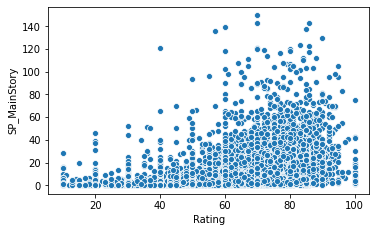

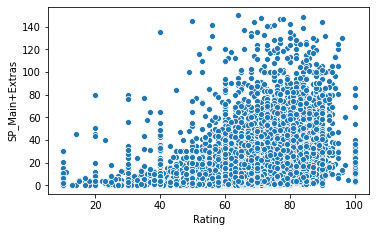

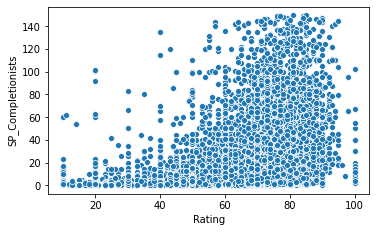

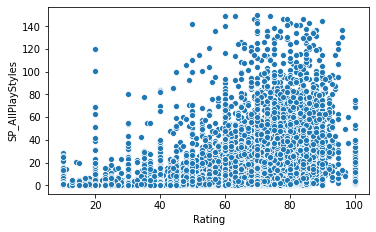

In [53]:
spType = ["SP_MainStory", "SP_Main+Extras", "SP_Completionists", "SP_AllPlayStyles"]

rating = dataAux_desp["Rating"]

for sp in spType:

    fig, axs = plt.subplots()
    fig.tight_layout(pad = 4)


    spTime = dataAux_desp[sp].apply(lambda x: get_mainStoryFormatted(x))
    sns.scatterplot(rating[spTime < 150], spTime[spTime < 150], ax = axs);  

# Top Genres by count

In [54]:
r_genres = re.compile('^G\_.*')
findGenCols = np.vectorize(lambda x:bool(r_genres.search(x)))

cols_bool = findGenCols(dataAux_desp.columns.values)
data_genres = dataAux_desp[dataAux_desp.columns[cols_bool]]

r_nums = re.compile('^N\_.*')
findNumsCols = np.vectorize(lambda x:bool(r_nums.search(x)))

cols_bool = findNumsCols(dataAux_desp.columns.values)
data_num_platforms = dataAux_desp[dataAux_desp.columns[cols_bool]]

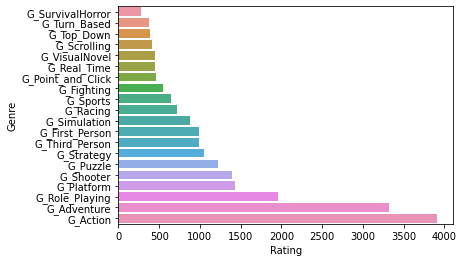

In [55]:
genres_sums = data_genres.sum(axis=0).sort_values()

top_genres_sums = genres_sums[genres_sums.values > 250]

ax = sns.barplot(top_genres_sums.values, top_genres_sums.index)
ax.set(xlabel='Rating', ylabel='Genre');

# Top Platform N by count and rating

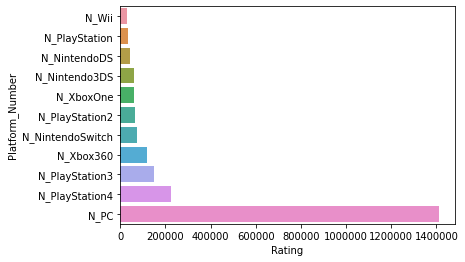

In [56]:
n_platform_sums = data_num_platforms.sum(axis=0).sort_values().astype(int)
top_n_platform_sums = n_platform_sums[n_platform_sums.values > 25000]

ax = sns.barplot(top_n_platform_sums.values, top_n_platform_sums.index)
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.set(xlabel='Rating', ylabel='Platform_Number');

# Rating vs SP-Main Story vs (Developers/Publishers)

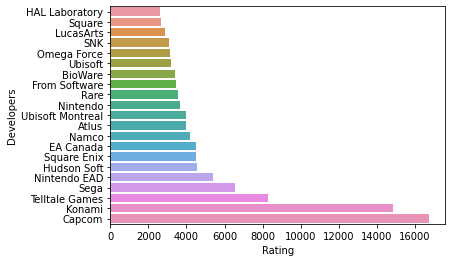

In [57]:
developers_by_rating = dataAux_desp[["Developers", "Rating"]].groupby(["Developers"]).sum().sort_values(by=["Rating"])
top_developers_by_rating = pd.DataFrame(developers_by_rating.values, developers_by_rating.index)

top_developers_by_ratingAux = top_developers_by_rating[top_developers_by_rating[0] > 2500]


ax = sns.barplot(top_developers_by_ratingAux[0].values, top_developers_by_ratingAux.index)
ax.set(xlabel='Rating', ylabel='Developers');

In [58]:
spMainStory = dataAux_desp["SP_MainStory"].apply(lambda x: get_mainStoryFormatted(x))
rating = dataAux_desp["Rating"]

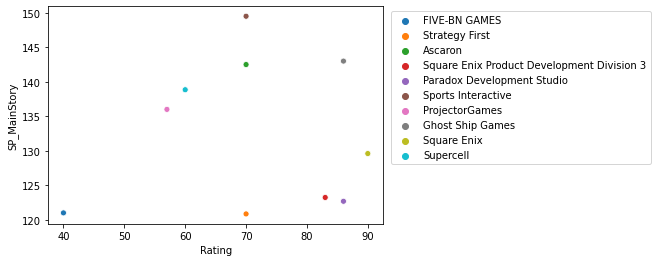

In [59]:
developers = dataAux_desp["Developers"]

sns.scatterplot(rating[(spMainStory < 150) & (spMainStory > 120)], spMainStory[(spMainStory < 150) & (spMainStory > 120)]
                , hue=developers[(spMainStory < 150) & (spMainStory > 120)].values)
plt.legend(bbox_to_anchor=(1.01, 1));

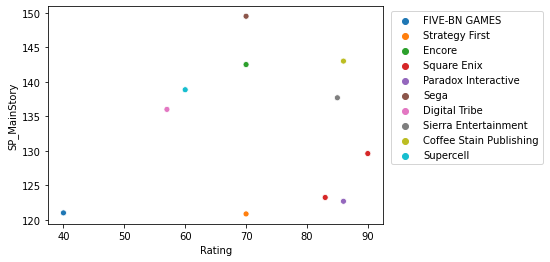

In [60]:
publishers = dataAux_desp["Publishers"]

sns.scatterplot(rating[(spMainStory < 150) & (spMainStory > 120)], spMainStory[(spMainStory < 150) & (spMainStory > 120)]
                , hue=publishers[(spMainStory < 150) & (spMainStory > 120)].values)
plt.legend(bbox_to_anchor=(1.01, 1));

# Rating vs Main Story vs Genre

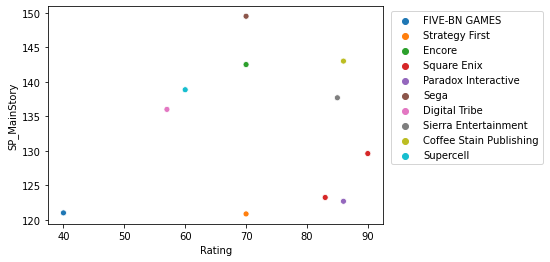

In [61]:
publishers = dataAux_desp["Publishers"]

sns.scatterplot(rating[(spMainStory < 150) & (spMainStory > 120)], spMainStory[(spMainStory < 150) & (spMainStory > 120)]
                , hue=publishers[(spMainStory < 150) & (spMainStory > 120)].values)
plt.legend(bbox_to_anchor=(1.01, 1));

# Correlation Rating vs all SP

In [62]:

rating = dataAux_desp["Rating"]

for sp in spType:

    spTime = dataAux_desp[sp].apply(lambda x: get_mainStoryFormatted(x))
    gamesData = {sp: spTime,
        'Rating': rating
        }
    df = pd.DataFrame(gamesData)
    
    print(df.corr())

              SP_MainStory    Rating
SP_MainStory      1.000000  0.162362
Rating            0.162362  1.000000
                SP_Main+Extras    Rating
SP_Main+Extras        1.000000  0.091958
Rating                0.091958  1.000000
                   SP_Completionists    Rating
SP_Completionists           1.000000  0.103966
Rating                      0.103966  1.000000
                  SP_AllPlayStyles    Rating
SP_AllPlayStyles          1.000000  0.060153
Rating                    0.060153  1.000000


In [63]:
#SE DEJAN FUERA: Name, description, Playable ON, Genres, Additional Content, Speedrun, Main Game, Multi-Player
#SE CONVIERTEN A DUMMIES: Publishers y Developers
#SP_MAIN STORY, EXTRaSCOMPLETIONISTS Y PLAYSTYLES se saca solo el primero y se pasa a horas
#No se que hacer con Platform

In [64]:
dataFrame_VIF = dataAux_desp.copy()
dataFrame_VIF = dataFrame_VIF.drop(columns=['Additional Content', 'Speedrun',
                                            'name', 'description', 'Playable On', 
                                            'Genres', 'Platform', 'Multi-Player', 'Main Game'])
dataFrame_VIF.head()

,NA,EU,JP,Retirement,Type,Rating,Publishers,Developers,SP_MainStory,SP_Main+Extras,SP_Completionists,SP_AllPlayStyles,N_PC,N_Nintendo3DS,N_SegaMasterSystem,N_PlayStation3,N_PlayStation4,N_Xbox360,N_NintendoSwitch,N_XboxOne,N_NES,N_PlayStationVita,N_PlayStation,N_Mobile,N_WiiU,N_GameBoyAdvance,N_ZXSpectrum,N_Arcade,N_SegaMegaDrive_Genesis,N_PlayStation2,N_NintendoDS,N_PSP,N_NintendoGameCube,N_SegaSaturn,N_Wii,N_Amiga,N_GameBoyColor,N_Emulated,N_NECPC_9801_21,N_Nintendo64,N_SuperNintendo,N_GoogleStadia,N_Atari2600,N_PlayStationVR,N_Browser,N_Xbox,N_GameBoy,N_N_Gage,N_VirtualBoy,N_PCVR,N_PlayStationNow,N_OculusQuest,N_Dreamcast,N_SegaCD,N_AppleII,N_TurboGrafx_16,N_AtariJaguar,N_NeoGeo,N_OnLive,N_SegaGameGear,N_AtariLynx,N_TurboGrafx_CD,N_Commodore64,N_NeoGeoPocket,N_Atari5200,N_Sega32X,N_WonderSwan,N_Atari7800,N_Game_Watch,N_3DO,N_Ouya,N_MSX,N_NeoGeoCD,G_Scrolling,G_Shooter,G_Top_Down,G_Real_Time,G_Action,G_Role_Playing,G_First_Person,G_Adventure,G_Puzzle,G_Strategy,G_Multidirectional,G_Platform,G_SurvivalHorror,G_Point_and_Click,G_Compilation,G_Tactical,G_Arcade,G_Racing_Driving,G_Turn_Based,G_Text,G_Fighting,G_Pinball,G_Horror,G_Survival,G_Third_Person,G_HiddenObject,G_MassivelyMultiplayer,G_Racing,G_Simulation,G_Stealth,G_Sports,G_BoardGame,G_TowerDefense,G_Beat_emUp,G_HackandSlash,G_On_Rails,G_VisualNovel,G_City_Building,G_Roguelike,G_InteractiveArt,G_OpenWorld,G_Party,G_CarCombat,G_Sandbox,G_VirtualReality,G_Side,G_VehicularCombat,G_BattleArena,G_Music_Rhythm,G_Educational,G_FlightCombat,G_CardGame,G_Flight,G_Fitness,G_Strategy_Tactical,G_Isometric,G_Platformer,G_role_playing,G_CombatFlightSimulator,G_Third_person,G_action_adventure,G_side_scroller,G_Side_scroller,G_Shoot_emup,G_Flightsimulator,G_Shoot_em_up,G_Top_down,G_3_D,G_Survivalhorror,G_actionadventure,G_action,G_adventure,G_City_building,G_Real_timeStrategy,G_Light_GunShooter,G_Third_personshooter,G_MechaSimulation,G_Side_Scroller,G_Shoot_emUp,G_Beat_emup,G_RPG,G_Graphicadventure,G_Point_and_clickadventure,G_Role_playinggame,G_Action_adventuregame,G_Stealthgame,G_Beat,G_Real_timetactics,G_platformer,G_Casual,G_Indie,G_hackandslash,G_educational,G_Music,G_post_retro,G_Scrollingshooter,G_music,G_Various,G_Fightinggame,G_Visualnovel,G_Americanfootball,G_Hackandslash,G_Vehicularcombat,G_puzzle,G_First_person,G_Tacticalshooter,G_Family,G_first_personshooter,G_Action_adventure,G_platforming,G_ActionRPG,G_Adventuregame,G_Third_personShooter,G_Mini_Games,G_FMV,G_FamilyGames,G_Sidescrolling,G_platform,G_Rhythm,G_Exercise,G_Third_personhackandslash,G_Firstperson,G_Sport,G_minigames,G_First_personshooter,G_survivalhorror,G_Real_TimeStrategy,G_DungeonCrawl,G_Role_playing,G_digitalpet,G_Dramatic_InnovativeRPG,G_third_personshooter,G_Real_timeTactics,G_interactivemovie,G_roleplaying,G_Aerialcombat,G_Driving,G_Third_PersonShooter,G_Sciencefiction,G_Real_timestrategy,G_Godgame,G_Computerrole_playinggame,G_Tacticalaction,G_Cardbattle,G_turn_basedstrategy,G_turn_basedtactics,G_Hack_and_slash,G_Runandgun,G_Simulator,G_Tacticalrole_playinggame,G_sandbox,G_CombatSimulation,G_Tactics,G_Real_timetacticalshooter,G_strategyside_scroller,G_Hack_n_Slash,G_MedievalFantasyAction,G_Shooting,G_flightsimulator,G_RTS,G_Socialsimulation,G_Puzzlegame,G_City_Builder,G_Spacesimulation,G_Golf,G_shooter,G_First_personShooter,G_DungeonCrawler,G_dungeoncrawl,G_Side_scrollingplatform,G_shoot_emup,G_graphicadventure,G_3DPlatform,G_Platforming,G_railshooter,G_Sportsgame,G_Turn_BasedStrategy,G_Wrestling,G_Side_scrolling,G_Moba,G_Turn_basedstrategy,G_CardBattle,G_Psychologicalhorror,G_Mecha,G_strategy,G_Stealth_basedgame,G_collectiblecardgame,G_turn_basedtactical,G_Stealthaction,G_Mechasimulationgame,G_runandgun,G_arcade,G_Crossover,G_Beat_emup,G_Platformgame,G_Computerrole_playing,G_First_PersonShooter,G_ActionAdventure,G_StrategyRPG,G_TacticalShooter,G_Openworld,G_Maze,G_Actionrole_playing,G_Rhythmgame,G_stealth,G_Interactivemovie,G_Spacesimulator,G_TBS,G_Third_personactionadventure,G_Western,G_Firstpersonshoo

In [65]:
spType = ["SP_MainStory", "SP_Main+Extras", "SP_Completionists", "SP_AllPlayStyles"]


for sp in spType:

    dataFrame_VIF[sp] =  dataFrame_VIF[sp].apply(lambda x: get_mainStoryFormatted(x))

dataFrame_VIF.head()

,NA,EU,JP,Retirement,Type,Rating,Publishers,Developers,SP_MainStory,SP_Main+Extras,SP_Completionists,SP_AllPlayStyles,N_PC,N_Nintendo3DS,N_SegaMasterSystem,N_PlayStation3,N_PlayStation4,N_Xbox360,N_NintendoSwitch,N_XboxOne,N_NES,N_PlayStationVita,N_PlayStation,N_Mobile,N_WiiU,N_GameBoyAdvance,N_ZXSpectrum,N_Arcade,N_SegaMegaDrive_Genesis,N_PlayStation2,N_NintendoDS,N_PSP,N_NintendoGameCube,N_SegaSaturn,N_Wii,N_Amiga,N_GameBoyColor,N_Emulated,N_NECPC_9801_21,N_Nintendo64,N_SuperNintendo,N_GoogleStadia,N_Atari2600,N_PlayStationVR,N_Browser,N_Xbox,N_GameBoy,N_N_Gage,N_VirtualBoy,N_PCVR,N_PlayStationNow,N_OculusQuest,N_Dreamcast,N_SegaCD,N_AppleII,N_TurboGrafx_16,N_AtariJaguar,N_NeoGeo,N_OnLive,N_SegaGameGear,N_AtariLynx,N_TurboGrafx_CD,N_Commodore64,N_NeoGeoPocket,N_Atari5200,N_Sega32X,N_WonderSwan,N_Atari7800,N_Game_Watch,N_3DO,N_Ouya,N_MSX,N_NeoGeoCD,G_Scrolling,G_Shooter,G_Top_Down,G_Real_Time,G_Action,G_Role_Playing,G_First_Person,G_Adventure,G_Puzzle,G_Strategy,G_Multidirectional,G_Platform,G_SurvivalHorror,G_Point_and_Click,G_Compilation,G_Tactical,G_Arcade,G_Racing_Driving,G_Turn_Based,G_Text,G_Fighting,G_Pinball,G_Horror,G_Survival,G_Third_Person,G_HiddenObject,G_MassivelyMultiplayer,G_Racing,G_Simulation,G_Stealth,G_Sports,G_BoardGame,G_TowerDefense,G_Beat_emUp,G_HackandSlash,G_On_Rails,G_VisualNovel,G_City_Building,G_Roguelike,G_InteractiveArt,G_OpenWorld,G_Party,G_CarCombat,G_Sandbox,G_VirtualReality,G_Side,G_VehicularCombat,G_BattleArena,G_Music_Rhythm,G_Educational,G_FlightCombat,G_CardGame,G_Flight,G_Fitness,G_Strategy_Tactical,G_Isometric,G_Platformer,G_role_playing,G_CombatFlightSimulator,G_Third_person,G_action_adventure,G_side_scroller,G_Side_scroller,G_Shoot_emup,G_Flightsimulator,G_Shoot_em_up,G_Top_down,G_3_D,G_Survivalhorror,G_actionadventure,G_action,G_adventure,G_City_building,G_Real_timeStrategy,G_Light_GunShooter,G_Third_personshooter,G_MechaSimulation,G_Side_Scroller,G_Shoot_emUp,G_Beat_emup,G_RPG,G_Graphicadventure,G_Point_and_clickadventure,G_Role_playinggame,G_Action_adventuregame,G_Stealthgame,G_Beat,G_Real_timetactics,G_platformer,G_Casual,G_Indie,G_hackandslash,G_educational,G_Music,G_post_retro,G_Scrollingshooter,G_music,G_Various,G_Fightinggame,G_Visualnovel,G_Americanfootball,G_Hackandslash,G_Vehicularcombat,G_puzzle,G_First_person,G_Tacticalshooter,G_Family,G_first_personshooter,G_Action_adventure,G_platforming,G_ActionRPG,G_Adventuregame,G_Third_personShooter,G_Mini_Games,G_FMV,G_FamilyGames,G_Sidescrolling,G_platform,G_Rhythm,G_Exercise,G_Third_personhackandslash,G_Firstperson,G_Sport,G_minigames,G_First_personshooter,G_survivalhorror,G_Real_TimeStrategy,G_DungeonCrawl,G_Role_playing,G_digitalpet,G_Dramatic_InnovativeRPG,G_third_personshooter,G_Real_timeTactics,G_interactivemovie,G_roleplaying,G_Aerialcombat,G_Driving,G_Third_PersonShooter,G_Sciencefiction,G_Real_timestrategy,G_Godgame,G_Computerrole_playinggame,G_Tacticalaction,G_Cardbattle,G_turn_basedstrategy,G_turn_basedtactics,G_Hack_and_slash,G_Runandgun,G_Simulator,G_Tacticalrole_playinggame,G_sandbox,G_CombatSimulation,G_Tactics,G_Real_timetacticalshooter,G_strategyside_scroller,G_Hack_n_Slash,G_MedievalFantasyAction,G_Shooting,G_flightsimulator,G_RTS,G_Socialsimulation,G_Puzzlegame,G_City_Builder,G_Spacesimulation,G_Golf,G_shooter,G_First_personShooter,G_DungeonCrawler,G_dungeoncrawl,G_Side_scrollingplatform,G_shoot_emup,G_graphicadventure,G_3DPlatform,G_Platforming,G_railshooter,G_Sportsgame,G_Turn_BasedStrategy,G_Wrestling,G_Side_scrolling,G_Moba,G_Turn_basedstrategy,G_CardBattle,G_Psychologicalhorror,G_Mecha,G_strategy,G_Stealth_basedgame,G_collectiblecardgame,G_turn_basedtactical,G_Stealthaction,G_Mechasimulationgame,G_runandgun,G_arcade,G_Crossover,G_Beat_emup,G_Platformgame,G_Computerrole_playing,G_First_PersonShooter,G_ActionAdventure,G_StrategyRPG,G_TacticalShooter,G_Openworld,G_Maze,G_Actionrole_playing,G_Rhythmgame,G_stealth,G_Interactivemovie,G_Spacesimulator,G_TBS,G_Third_personactionadventure,G_Western,G_Firstpersonshoo

In [66]:
dataFrame_VIF = pd.get_dummies(dataFrame_VIF, columns=['Type'])

In [67]:
len(dataFrame_VIF.index)

16735

In [68]:
developers_count = dataFrame_VIF.groupby(by=["Developers"])["Developers"].count().sort_values()
developers_limit_list = developers_count.index[np.where(developers_count < 10)]

dataFrame_VIF["Developers"] = dataFrame_VIF["Developers"].replace(developers_limit_list, "OtherDevelopers")
dataFrame_VIF["Developers"]

3                    NaN
7                    NaN
11       OtherDevelopers
16        GSC Game World
22       OtherDevelopers
              ...       
69121       Inti Creates
69237    OtherDevelopers
69360                NaN
69817    OtherDevelopers
69985    OtherDevelopers
Name: Developers, Length: 16735, dtype: object

In [69]:
publishers_count = dataFrame_VIF.groupby(by=["Publishers"])["Publishers"].count().sort_values()
publishers_limit_list = publishers_count.index[np.where(publishers_count < 10)]
dataFrame_VIF["Publishers"] = dataFrame_VIF["Publishers"].replace(publishers_limit_list, "OtherPublishers")


In [70]:
dataFrame_VIF = pd.get_dummies(dataFrame_VIF, columns=['Publishers'])

In [71]:
dataFrame_VIF = pd.get_dummies(dataFrame_VIF, columns=['Developers'])

In [72]:

import datetime

def convert_seconds(x):
    try:
        return (datetime.datetime.combine(x, datetime.datetime.min.time())-
                datetime.datetime(1970,1,1)).total_seconds()
    except Exception as e:
        return x

dataFrame_VIF["NA"] = dataFrame_VIF["NA"].apply(lambda x: convert_seconds(x))
dataFrame_VIF["JP"] = dataFrame_VIF["JP"].apply(lambda x: convert_seconds(x))
dataFrame_VIF["EU"] = dataFrame_VIF["EU"].apply(lambda x: convert_seconds(x))

In [73]:
def renaming_fun(x):
    renameCol = changeWord(''.join(x.split()))
    return renameCol

dataFrame_VIF = dataFrame_VIF.rename(columns=renaming_fun)

In [74]:
features = list(dataFrame_VIF.columns)
features.remove('Rating')
features = "+".join(features)


In [75]:
dataFrame_VIF.head()

,NA,EU,JP,Retirement,Rating,SP_MainStory,SP_Main_Extras,SP_Completionists,SP_AllPlayStyles,N_PC,N_Nintendo3DS,N_SegaMasterSystem,N_PlayStation3,N_PlayStation4,N_Xbox360,N_NintendoSwitch,N_XboxOne,N_NES,N_PlayStationVita,N_PlayStation,N_Mobile,N_WiiU,N_GameBoyAdvance,N_ZXSpectrum,N_Arcade,N_SegaMegaDrive_Genesis,N_PlayStation2,N_NintendoDS,N_PSP,N_NintendoGameCube,N_SegaSaturn,N_Wii,N_Amiga,N_GameBoyColor,N_Emulated,N_NECPC_9801_21,N_Nintendo64,N_SuperNintendo,N_GoogleStadia,N_Atari2600,N_PlayStationVR,N_Browser,N_Xbox,N_GameBoy,N_N_Gage,N_VirtualBoy,N_PCVR,N_PlayStationNow,N_OculusQuest,N_Dreamcast,N_SegaCD,N_AppleII,N_TurboGrafx_16,N_AtariJaguar,N_NeoGeo,N_OnLive,N_SegaGameGear,N_AtariLynx,N_TurboGrafx_CD,N_Commodore64,N_NeoGeoPocket,N_Atari5200,N_Sega32X,N_WonderSwan,N_Atari7800,N_Game_Watch,N_3DO,N_Ouya,N_MSX,N_NeoGeoCD,G_Scrolling,G_Shooter,G_Top_Down,G_Real_Time,G_Action,G_Role_Playing,G_First_Person,G_Adventure,G_Puzzle,G_Strategy,G_Multidirectional,G_Platform,G_SurvivalHorror,G_Point_and_Click,G_Compilation,G_Tactical,G_Arcade,G_Racing_Driving,G_Turn_Based,G_Text,G_Fighting,G_Pinball,G_Horror,G_Survival,G_Third_Person,G_HiddenObject,G_MassivelyMultiplayer,G_Racing,G_Simulation,G_Stealth,G_Sports,G_BoardGame,G_TowerDefense,G_Beat_emUp,G_HackandSlash,G_On_Rails,G_VisualNovel,G_City_Building,G_Roguelike,G_InteractiveArt,G_OpenWorld,G_Party,G_CarCombat,G_Sandbox,G_VirtualReality,G_Side,G_VehicularCombat,G_BattleArena,G_Music_Rhythm,G_Educational,G_FlightCombat,G_CardGame,G_Flight,G_Fitness,G_Strategy_Tactical,G_Isometric,G_Platformer,G_role_playing,G_CombatFlightSimulator,G_Third_person,G_action_adventure,G_side_scroller,G_Side_scroller,G_Shoot_emup,G_Flightsimulator,G_Shoot_em_up,G_Top_down,G_3_D,G_Survivalhorror,G_actionadventure,G_action,G_adventure,G_City_building,G_Real_timeStrategy,G_Light_GunShooter,G_Third_personshooter,G_MechaSimulation,G_Side_Scroller,G_Shoot_emUp,G_Beat_emup,G_RPG,G_Graphicadventure,G_Point_and_clickadventure,G_Role_playinggame,G_Action_adventuregame,G_Stealthgame,G_Beat,G_Real_timetactics,G_platformer,G_Casual,G_Indie,G_hackandslash,G_educational,G_Music,G_post_retro,G_Scrollingshooter,G_music,G_Various,G_Fightinggame,G_Visualnovel,G_Americanfootball,G_Hackandslash,G_Vehicularcombat,G_puzzle,G_First_person,G_Tacticalshooter,G_Family,G_first_personshooter,G_Action_adventure,G_platforming,G_ActionRPG,G_Adventuregame,G_Third_personShooter,G_Mini_Games,G_FMV,G_FamilyGames,G_Sidescrolling,G_platform,G_Rhythm,G_Exercise,G_Third_personhackandslash,G_Firstperson,G_Sport,G_minigames,G_First_personshooter,G_survivalhorror,G_Real_TimeStrategy,G_DungeonCrawl,G_Role_playing,G_digitalpet,G_Dramatic_InnovativeRPG,G_third_personshooter,G_Real_timeTactics,G_interactivemovie,G_roleplaying,G_Aerialcombat,G_Driving,G_Third_PersonShooter,G_Sciencefiction,G_Real_timestrategy,G_Godgame,G_Computerrole_playinggame,G_Tacticalaction,G_Cardbattle,G_turn_basedstrategy,G_turn_basedtactics,G_Hack_and_slash,G_Runandgun,G_Simulator,G_Tacticalrole_playinggame,G_sandbox,G_CombatSimulation,G_Tactics,G_Real_timetacticalshooter,G_strategyside_scroller,G_Hack_n_Slash,G_MedievalFantasyAction,G_Shooting,G_flightsimulator,G_RTS,G_Socialsimulation,G_Puzzlegame,G_City_Builder,G_Spacesimulation,G_Golf,G_shooter,G_First_personShooter,G_DungeonCrawler,G_dungeoncrawl,G_Side_scrollingplatform,G_shoot_emup,G_graphicadventure,G_3DPlatform,G_Platforming,G_railshooter,G_Sportsgame,G_Turn_BasedStrategy,G_Wrestling,G_Side_scrolling,G_Moba,G_Turn_basedstrategy,G_CardBattle,G_Psychologicalhorror,G_Mecha,G_strategy,G_Stealth_basedgame,G_collectiblecardgame,G_turn_basedtactical,G_Stealthaction,G_Mechasimulationgame,G_runandgun,G_arcade,G_Crossover,G_Beat_emup,G_Platformgame,G_Computerrole_playing,G_First_PersonShooter,G_ActionAdventure,G_StrategyRPG,G_TacticalShooter,G_Openworld,G_Maze,G_Actionrole_playing,G_Rhythmgame,G_stealth,G_Interactivemovie,G_Spacesimulator,G_TBS,G_Third_personactionadventure,G_Western,G_Firstpersonshooter,G_beat_em_up,G_RailShoo

In [76]:
# get y and X dataframes based on this regression:
y, X = dmatrices('Rating ~' + features, dataFrame_VIF, return_type='dataframe')
X.values


array([[1.0000000e+00, 1.5674688e+09, 1.5674688e+09, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.4156640e+09, 1.4157504e+09, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.4217120e+09, 1.4217120e+09, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.0000000e+00, 1.5851808e+09, 1.5851808e+09, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.5949440e+09, 1.5949440e+09, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.5919200e+09, 1.5919200e+09, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [77]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns


/home/agorgues/miniconda3/envs/tfm/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [78]:
vif.round(1)

,VIF Factor,features
0,85.5,Intercept
1,84.4,NA
2,45.0,EU
3,61.3,JP
4,2.3,Retirement
...,...,...
725,NaN,Developers_WingedCloud
726,NaN,Developers_WinterWolves
727,1.7,Developers_Yuke_s
728,NaN,Developers_ZonitronProductions
